# **Sentence Classification**

In [15]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('text_train.csv')
#df = df.append(pd.read_csv('text_test.csv'))
# Use pd.concat to combine the DataFrames instead of append
df = pd.concat([df, pd.read_csv('text_test.csv')], ignore_index=True)
# ignore_index=True ensures a continuous index in the combined DataFrame
display(df.head())



Saving text_test.csv to text_test (3).csv
Saving text_train.csv to text_train (3).csv


,wav_file,label,transcription
0,Ses02F_impro04_F012,2,or they ll never talk to me again .
1,Ses03F_script02_1_M030,4,for real ?
2,Ses02F_script03_2_M015,2,nothing .
3,Ses02F_script02_2_M025,2,you wanna get married again ?
4,Ses04M_script03_1_M021,1,let s savor the delight of the moment . come a...


In [16]:
col = ['label', 'transcription']
df = df[col]

In [17]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [18]:
df.columns = ['label', 'transcription']

In [19]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

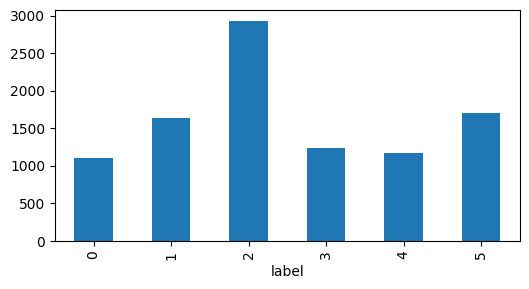

In [21]:
fig = plt.figure(figsize=(6,3))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [23]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(9797, 2464)


In [24]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

In [25]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.614
Test Set F-score =  0.607
Test Set Precision =  0.638
Test Set Recall =  0.623
Confusion matrix, without normalization
[[ 86  15  97  14  13  11]
 [  2 192  83  24  12  25]
 [ 35  26 386  50  17  57]
 [  0   0   0 243   0   0]
 [  0   0   0  48 180   0]
 [  8  33 137  33  17 116]]


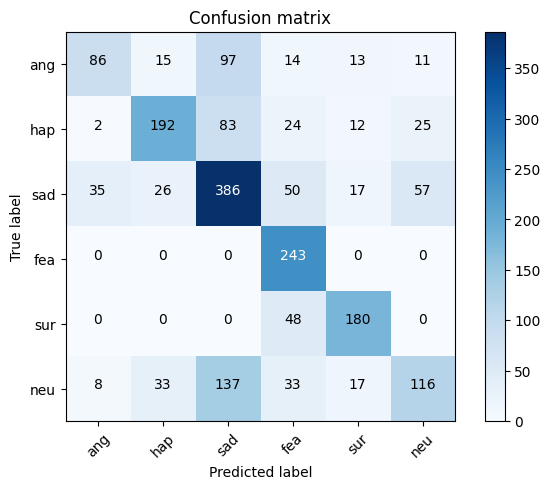

In [27]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Set Accuracy =  0.614
Test Set F-score =  0.627
Test Set Precision =  0.672
Test Set Recall =  0.608
Confusion matrix, without normalization
[[ 96  12  92   1  16  19]
 [  5 202  75   9  14  33]
 [ 38  22 419   2  17  73]
 [  0   0  55 188   0   0]
 [  0   1  48   0 179   0]
 [ 10  29 160   4  21 120]]


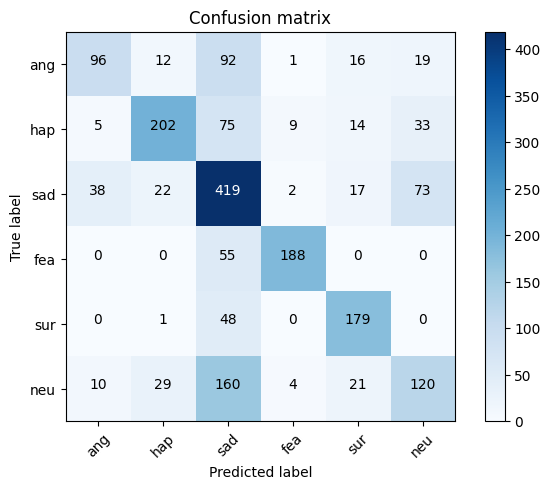

In [28]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# **LSTM**

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM  # Import from tensorflow.keras

# Define the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=x_train.shape[1]))
model.add(LSTM(128, return_sequences=False))  # Add LSTM layer
model.add(Dense(64, activation='relu'))       # Fully connected layer
model.add(Dense(len(set(y_train)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=64)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 845s 7s/step - accuracy: 0.2870 - loss: 1.7420
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 979s 8s/step - accuracy: 0.3057 - loss: 1.7247
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 839s 7s/step - accuracy: 0.2973 - loss: 1.7308
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 805s 7s/step - accuracy: 0.3053 - loss: 1.7261
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 798s 6s/step - accuracy: 0.3013 - loss: 1.7300
